# Mouse Bone Marrow - merging annotated samples from Dahlin et al.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import glob

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

results_file = './write/Dahlin_mou_BM_pp.h5ad'

scanpy==1.4.4+40.gbd5f862 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

## Load 
Here we load the pre-processed datasets (which has been annotated), and the raw matrices (which won't be filtered on the gene level). 

### Raw data

In [22]:
file_paths = '../../Munich/datasets/mouse/Dahlin_BoneMarrow/GSE107727_RAW/analyzed/'
adatas_raw = []
for i in glob.glob(file_paths+'*.txt.gz'):
    print(i)
    adatas_raw.append(sc.read(i, cache=True)) 

../../Munich/datasets/mouse/Dahlin_BoneMarrow/GSE107727_RAW/analyzed/GSM2877133_SIGAG8_counts.txt.gz
... reading from cache file cache/..-..-Munich-datasets-mouse-Dahlin_BoneMarrow-GSE107727_RAW-analyzed-GSM2877133_SIGAG8_counts.h5ad
../../Munich/datasets/mouse/Dahlin_BoneMarrow/GSE107727_RAW/analyzed/GSM2877129_SIGAD1_counts.txt.gz
... reading from cache file cache/..-..-Munich-datasets-mouse-Dahlin_BoneMarrow-GSE107727_RAW-analyzed-GSM2877129_SIGAD1_counts.h5ad
../../Munich/datasets/mouse/Dahlin_BoneMarrow/GSE107727_RAW/analyzed/GSM2877132_SIGAH1_counts.txt.gz
... reading from cache file cache/..-..-Munich-datasets-mouse-Dahlin_BoneMarrow-GSE107727_RAW-analyzed-GSM2877132_SIGAH1_counts.h5ad
../../Munich/datasets/mouse/Dahlin_BoneMarrow/GSE107727_RAW/analyzed/GSM2877130_SIGAF1_counts.txt.gz
... reading from cache file cache/..-..-Munich-datasets-mouse-Dahlin_BoneMarrow-GSE107727_RAW-analyzed-GSM2877130_SIGAF1_counts.h5ad


In [23]:
samples = ['Dahlin_1', 'Dahlin_4', 'Dahlin_3', 'Dahlin_2']
mapEnsembl2gene_symbol = pd.read_csv('../../Munich/datasets/mouse/Dahlin_BoneMarrow/ensembl2gene_symbol.tsv', header=None, sep='\t')
mapEnsembl2gene_symbol.rename(columns={0:'gene_ensembl', 1:'gene_symbol'}, inplace=True)
# Loop to annotate data
for i in range(len(adatas_raw)):
    adata_tmp = adatas_raw[i]
    adata_tmp = adata_tmp.transpose()
    
    #Annotate data
    adata_tmp.obs.index.rename('barcode', inplace=True)
    adata_tmp.obs['batch'] = [samples[i]]*adata_tmp.n_obs
    adata_tmp.obs['study'] = ['Dahlin_BM']*adata_tmp.n_obs
    adata_tmp.obs['chemistry'] = ['v2_10X']*adata_tmp.n_obs
    adata_tmp.obs['tissue'] = ['Bone_Marrow']*adata_tmp.n_obs
    adata_tmp.obs['species'] = ['Mouse']*adata_tmp.n_obs
    adata_tmp.obs['data_type'] = ['UMI']*adata_tmp.n_obs

    adata_tmp.var.index.names = ['gene_ensembl']
    adata_genes = adata_tmp.var.reset_index()
    # merge the two dataframes
    adata_genes_merge = adata_genes.merge(mapEnsembl2gene_symbol, how='left', on='gene_ensembl')
    adata_genes_merge.set_index('gene_symbol', inplace = True)
    adata_tmp.var = adata_genes_merge
    adata_tmp.var_names_make_unique()
    adatas_raw[i] = adata_tmp


In [24]:
adatas_raw[0].obs.head()

,batch,study,chemistry,tissue,species,data_type
barcode,,,,,,
AAACCTGAGGCAGGTT-1,Dahlin_1,Dahlin_BM,v2_10X,Bone_Marrow,Mouse,UMI
AAACCTGCAAGCTGAG-1,Dahlin_1,Dahlin_BM,v2_10X,Bone_Marrow,Mouse,UMI
AAACCTGCAGATGGGT-1,Dahlin_1,Dahlin_BM,v2_10X,Bone_Marrow,Mouse,UMI
AAACCTGCATACAGCT-1,Dahlin_1,Dahlin_BM,v2_10X,Bone_Marrow,Mouse,UMI
AAACCTGCATCACGTA-1,Dahlin_1,Dahlin_BM,v2_10X,Bone_Marrow,Mouse,UMI


In [25]:
# Concatenate to unique adata object
adata_raw = adatas_raw[0].concatenate(adatas_raw[1:], batch_key='sample_ID', batch_categories=samples)

In [26]:
adata_raw.obs.head()

,batch,chemistry,data_type,sample_ID,species,study,tissue
AAACCTGAGGCAGGTT-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Dahlin_1,Mouse,Dahlin_BM,Bone_Marrow
AAACCTGCAAGCTGAG-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Dahlin_1,Mouse,Dahlin_BM,Bone_Marrow
AAACCTGCAGATGGGT-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Dahlin_1,Mouse,Dahlin_BM,Bone_Marrow
AAACCTGCATACAGCT-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Dahlin_1,Mouse,Dahlin_BM,Bone_Marrow
AAACCTGCATCACGTA-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Dahlin_1,Mouse,Dahlin_BM,Bone_Marrow


In [27]:
adata_raw.obs.drop(columns=['sample_ID'], inplace=True)
adata_raw.obs.index.rename('barcode', inplace=True)
adata_raw.obs.head()

,batch,chemistry,data_type,species,study,tissue
barcode,,,,,,
AAACCTGAGGCAGGTT-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Mouse,Dahlin_BM,Bone_Marrow
AAACCTGCAAGCTGAG-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Mouse,Dahlin_BM,Bone_Marrow
AAACCTGCAGATGGGT-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Mouse,Dahlin_BM,Bone_Marrow
AAACCTGCATACAGCT-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Mouse,Dahlin_BM,Bone_Marrow
AAACCTGCATCACGTA-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Mouse,Dahlin_BM,Bone_Marrow


In [10]:
adata_raw.shape

(30494, 27998)

### Pre-processed data

In [11]:
file_paths = '../../Bone_Marrow_mouse/Dahlin_mouse_BM/write/'
adatas_pp = []
for i in glob.glob(file_paths+'*.h5ad'):
    print(i)
    adatas_pp.append(sc.read(i, cache=True)) 

../../Bone_Marrow_mouse/Dahlin_mouse_BM/write/BM_Dahlin_3.h5ad
../../Bone_Marrow_mouse/Dahlin_mouse_BM/write/BM_Dahlin_2.h5ad
../../Bone_Marrow_mouse/Dahlin_mouse_BM/write/BM_Dahlin_4.h5ad
../../Bone_Marrow_mouse/Dahlin_mouse_BM/write/BM_Dahlin_1.h5ad


In [12]:
samples = ['Dahlin_3', 'Dahlin_2', 'Dahlin_4', 'Dahlin_1']
for i in range(len(adatas_pp)):
    adata_tmp = adatas_pp[i]
    adata_obs = adata_tmp.obs.reset_index()
    adata_obs = adata_obs[['index', 'final_annotation', 'dpt_pseudotime', 'n_counts', 'n_genes', 'mt_frac']].rename(columns = {'index':'barcode'})
    adata_obs.set_index('barcode', inplace = True)
    adatas_pp[i].obs = adata_obs
    

In [19]:
# Concatenate to unique adata object
adata_pp = adatas_pp[0].concatenate(adatas_pp[1:], batch_key='sample_ID', batch_categories=samples)

In [20]:
adata_pp.obs.drop(columns=['sample_ID'], inplace = True)
adata_pp.obs.index.rename('barcode', inplace=True)
adata_pp.obs.head()

,dpt_pseudotime,final_annotation,mt_frac,n_counts,n_genes
barcode,,,,,
AAACCTGAGTTAACGA-1-Dahlin_3,0.319560,Megakaryocyte progenitors,0.028705,9197.0,3073
AAACCTGCAACGCACC-1-Dahlin_3,NaN,Lymphocyte progenitors,0.036939,3384.0,1717
AAACCTGCAATTCCTT-1-Dahlin_3,NaN,Lymphocyte progenitors,0.026477,6836.0,2641
AAACCTGCACCTTGTC-1-Dahlin_3,0.615284,Erythroid progenitors,0.026874,24485.0,5016
AAACCTGCATCCAACA-1-Dahlin_3,0.379302,Erythroid progenitors,0.030575,4677.0,1846


In [28]:
adata_raw.shape

(30494, 27998)

In [29]:
adata_pp.shape

(30405, 12155)

In [30]:
# Restrict to cells that passed QC and were annotated
adata_obs_raw = adata_raw.obs.reset_index()
adata_obs_pp = adata_pp.obs.reset_index()
adata_merged = adata_obs_raw.merge(adata_obs_pp, on='barcode', how='left')
adata_merged.set_index('barcode', inplace = True)
adata_raw.obs = adata_merged
adata_raw.obs.head()

,batch,chemistry,data_type,species,study,tissue,dpt_pseudotime,final_annotation,mt_frac,n_counts,n_genes
barcode,,,,,,,,,,,
AAACCTGAGGCAGGTT-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Mouse,Dahlin_BM,Bone_Marrow,0.859547,Erythrocytes,0.027973,30744.0,4452.0
AAACCTGCAAGCTGAG-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Mouse,Dahlin_BM,Bone_Marrow,NaN,Neutrophils,0.022213,16657.0,3369.0
AAACCTGCAGATGGGT-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Mouse,Dahlin_BM,Bone_Marrow,NaN,Lymphocyte progenitors,0.015106,16484.0,3372.0
AAACCTGCATACAGCT-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Mouse,Dahlin_BM,Bone_Marrow,0.739842,Erythrocytes,0.024411,34820.0,4648.0
AAACCTGCATCACGTA-1-Dahlin_1,Dahlin_1,v2_10X,UMI,Mouse,Dahlin_BM,Bone_Marrow,0.882839,Erythrocytes,0.020295,26213.0,4258.0


In [31]:
adata_raw = adata_raw[~pd.isnull(adata_raw.obs['final_annotation'])]
adata_raw.shape

(30405, 27998)

### Normalization

In [32]:
# Exclude genes that are = 0 in all cells
#Filter genes:
print('Total number of genes: {:d}'.format(adata_raw.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_raw, min_cells=1)
print('Number of genes after cell filter: {:d}'.format(adata_raw.n_vars))

Total number of genes: 27998
filtered out 9144 genes that are detectedin less than 1 cells


Trying to set attribute `.var` of view, making a copy.


Number of genes after cell filter: 18854


In [33]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata_raw.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:15)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:12)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:07)


In [34]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0     4799
1     4216
2     3457
3     3126
4     2447
5     2142
6     2066
7     2013
8     1803
9     1753
10    1382
11    1201
Name: groups, dtype: int64

In [35]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_raw.X.T

In [36]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [37]:
#Delete adata_pp
del adata_pp

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'final_annotation' as categorical


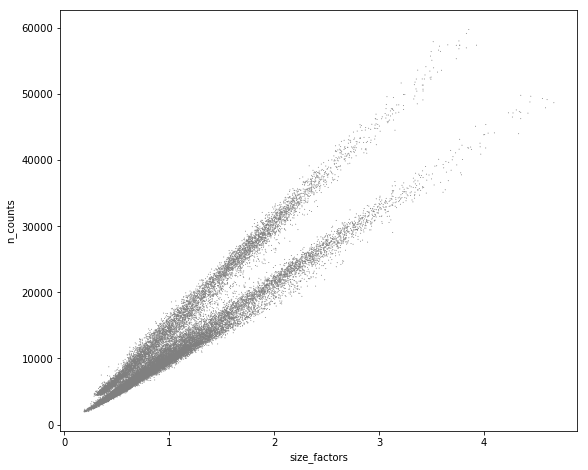

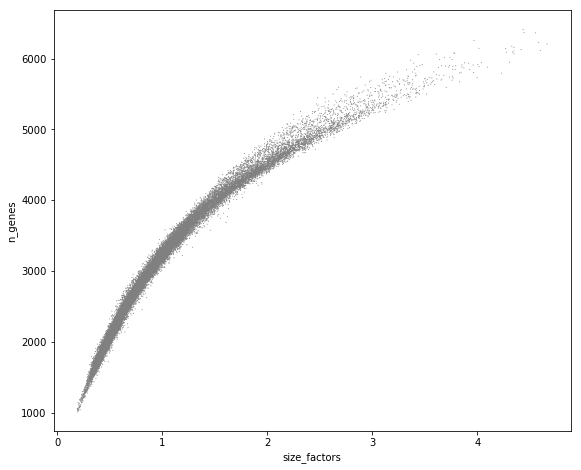

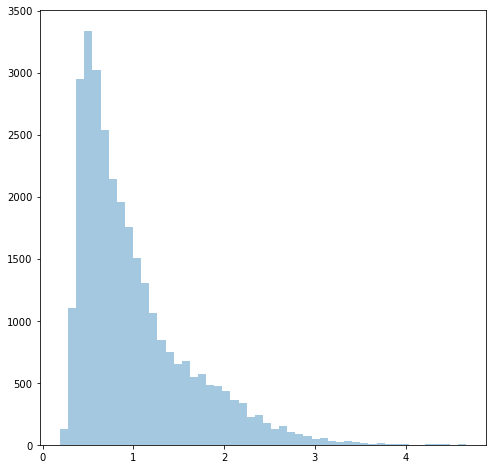

In [38]:
# Visualize the estimated size factors
adata_raw.obs['size_factors'] = size_factors

sc.pl.scatter(adata_raw, 'size_factors', 'n_counts')
sc.pl.scatter(adata_raw, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [39]:
#Keep the count data in a counts layer
adata_raw.layers["counts"] = adata_raw.X.copy()

In [40]:
#Normalize adata 
adata_raw.X /= adata_raw.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_raw)

In [41]:
adata_raw.write(results_file)